# Sentiment Analysis for Customer Feedback
In this project, we develop a sentiment analysis solution to gauge customer satisfaction.
## 1. Data Exploration & Preprocessing
### 1.1. Examine the Data

In [2]:
import pandas as pd
import numpy as np

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from gensim.models import KeyedVectors
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
# Load the dataset
df = pd.read_csv('bank_reviews3.csv')

# Display the first few rows
display(df.head())

# Show the structure and info
print('--- DataFrame Info ---')
df.info()

# Show summary statistics for numeric columns
print('--- Summary Statistics ---')
display(df.describe(include='all'))

,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,"Mar 21, 2020",New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,"Mar 20, 2020",Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,"Mar 20, 2020",Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,"Mar 20, 2020",Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,"Mar 20, 2020",Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                996 non-null    object 
 1   date                  1000 non-null   object 
 2   address               1000 non-null   object 
 3   bank                  1000 non-null   object 
 4   rating                1000 non-null   float64
 5   review_title_by_user  1000 non-null   object 
 6   review                1000 non-null   object 
 7   bank_image            1000 non-null   object 
 8   rating_title_by_user  1000 non-null   object 
 9   useful_count          1000 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 78.2+ KB
--- Summary Statistics ---


,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
count,996,1000,1000,1000,1000.000000,1000,1000,1000,1000,1000.000000
unique,620,110,107,10,NaN,352,999,10,10,NaN
top,ANONYMOUS,"Jan 20, 2020",Bangalore,review,NaN,"""Good Account""","In SBI customer care, they are not responding ...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,NaN
freq,117,26,245,285,NaN,105,2,285,550,NaN
mean,NaN,NaN,NaN,NaN,4.351500,NaN,NaN,NaN,NaN,2.752000
std,NaN,NaN,NaN,NaN,0.940788,NaN,NaN,NaN,NaN,7.638904
min,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,2.000000


#### Dataset Overview
- Rows: 1000
- Columns: 10
- Key Text Fields: `review_title_by_user`, `review`
- Metadata Fields: `author`, `date`, `address`, `bank`, `bank_image`, `rating`, `rating_title_by_user`, `useful_count`

In [4]:
# Check for missing values
print('--- Missing Values ---')
display(df.isnull().sum())

# Check for anomalies: e.g., unique values in rating, useful_count, etc.
print('--- Unique Values in Key Columns ---')
for col in ['bank', 'address', 'rating', 'useful_count', 'rating_title_by_user']:
    print(f'{col}:', df[col].unique()[:10], '...')

--- Missing Values ---


author                  4
date                    0
address                 0
bank                    0
rating                  0
review_title_by_user    0
review                  0
bank_image              0
rating_title_by_user    0
useful_count            0
dtype: int64

--- Unique Values in Key Columns ---
bank: ['SBI' 'Axis Bank' 'HDFC Bank' 'review' 'IDBI' 'Kotak' 'IndusInd Bank'
 'Canara Bank' 'Citibank' 'Punjab National Bank'] ...
address: ['New delhi' 'Kolkata' 'Hooghly' 'Pune' 'Bangalore' 'Hyderabad' 'Chennai'
 'Darbhanga' 'Jaipur' 'Nasik'] ...
rating: [4.  5.  3.  4.5 0.5 2.  3.5 1.5 1.  2.5] ...
useful_count: [133  89  48  52  22  37  44  35  29  28] ...
rating_title_by_user: ['Great!' 'Blown Away!' 'Satisfactory' 'Excellent!' 'Unacceptable'
 'Expected more' 'Pretty good' 'Bad' 'Really Bad' 'Just OK'] ...


##### Data Types & Structure
Most columns are of type string, except:
- `rating`: float (customer's numeric rating, e.g., 0.5 to 5.0)
- `useful_count`: integer (number of users who found the review useful)
##### Categorical & Numeric Insights
- `bank`: 10 unique banks (plus a generic 'review' label).
- `rating`: Ranges from 0.5 to 5.0 (steps of 0.5), with most ratings at 4.0 or 5.0.
- `rating_title_by_user`: 10 unique sentiment labels (e.g., "Blown Away!", "Great!", "Satisfactory", "Unacceptable", "Bad").
- `useful_count`: Ranges from 0 to 133, with a median of 0 (most reviews are not marked as useful by others).

##### Missing Values
- The author column has 4 missing values.
- All other columns are complete (no missing values).

In [5]:
# Fill missing author values with 'ANONYMOUS'
df['author'] = df['author'].fillna('ANONYMOUS')

Fill with "ANONYMOUS" to be consistent with other anonymous entries.

##### Anomalies & Observations
- The bank column contains a generic value "review" for some entries, which may need to be filtered or handled separately.
- The review field is almost always unique, indicating each row is a distinct customer feedback.
- The most common author is "ANONYMOUS" (117 times), suggesting many users prefer not to disclose their names.

We flag rows where bank == "review"

In [6]:
# Add a flag for generic reviews
df['is_generic_review'] = df['bank'].str.lower() == 'review'

### 1.2. Text Cleaning
To prepare the customer feedback text for sentiment analysis, we will:
- Convert all text to lowercase (normalization)
- Remove punctuation and irrelevant symbols
- Remove stop words (common words that add little meaning, e.g., 'the', 'is', 'and')
- Tokenize the text (split into individual words)
- Lemmatize each token (Lemmatization reduces words to their base or dictionary form (lemma)).

We will apply these steps to the 'review' column and display sample outputs to illustrate the transformations.

In [7]:
# Download NLTK resources if not already present
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sghas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sghas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sghas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sghas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

We use part-of-speech (POS) tagging with the lemmatizer. This provides more accurate normalization of words.

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Map POS tag to first character lemmatize() accepts"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def clean_text_pos(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation (but keep spaces)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize each token
    tagged_tokens = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return tokens
    
# Show before/after for a few samples
sample_reviews = df['review'].sample(3, random_state=42)
for i, review in enumerate(sample_reviews):
    print(f'Original Review {i+1}:', review)
    print(f'Cleaned Tokens with POS {i+1}:', clean_text_pos(review))
    print('-'*60)

# Apply cleaning to the whole column and store as new column
df['review_clean_tokens'] = df['review'].apply(clean_text_pos)

Original Review 1: I have been holding salary account with HDFC bank for the past 3 months.  The customer service and response are  good.  If I call the customer care also, they responding properly. This is a zero balance account, so no need to maintain minimum balance.
Cleaned Tokens with POS 1: ['hold', 'salary', 'account', 'hdfc', 'bank', 'past', 'month', 'customer', 'service', 'response', 'good', 'call', 'customer', 'care', 'also', 'respond', 'properly', 'zero', 'balance', 'account', 'need', 'maintain', 'minimum', 'balance']
------------------------------------------------------------
Original Review 2: I am holding salary account with HDFC Bank for more than 10 years. It is a zero balance account with no hidden charges. I use to get alert message on time whenever I do a transaction. ATM is near but branches are far of 10-15 km away from my place. ATM charges are applicable, if I do a transaction more than 5-6 times in a month. I use to get offers messages from bank.
Cleaned Tokens

- All reviews were lowercased, punctuation and non-alphabetic symbols removed.
- Stop words were filtered out.
- Text was tokenized into individual words.
- Tokens were lemmatized.
- The cleaned tokens are stored in a new column: `review_clean_tokens`.

### 1.3. Observations & Visualizations
After cleaning and lemmatizing the customer feedback text, we can explore the most common words and themes.
- The following visualizations help us understand what customers talk about most.
- We use a word cloud for a quick visual summary, and a bar chart for the most frequent words.

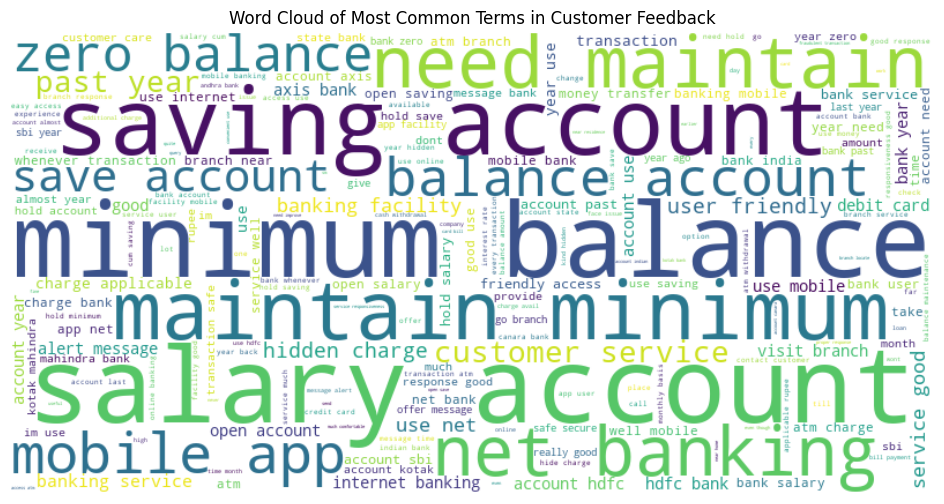

In [9]:
# Flatten the list of tokens
all_words = [word for tokens in df['review_clean_tokens'] for word in tokens]

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Terms in Customer Feedback')
plt.show()

The word cloud highlights the most frequently mentioned terms in customer feedback about banking services. The dominant presence of terms like "minimum balance," "maintain," "salary account," "saving account," "mobile app," and "net banking" suggests that customers are highly concerned with:
- Minimum Balance Requirements:

Many customers mention "minimum balance" and "maintain," indicating that maintaining a required balance is a significant topic, either as a pain point or a key feature they value (such as "zero balance" accounts).
- Account Types:

Terms like "salary account" and "saving account" are prominent, showing that feedback often centers around these account types, possibly regarding their features, benefits, or issues.
- Digital Banking Services:

The frequent appearance of "mobile app" and "net banking" reflects the growing importance of digital banking. Customers are likely sharing experiences, positive or negative, about the usability and reliability of these services.
- Customer Service:

The presence of "customer service" indicates that the quality of support remains a crucial aspect of customer satisfaction.

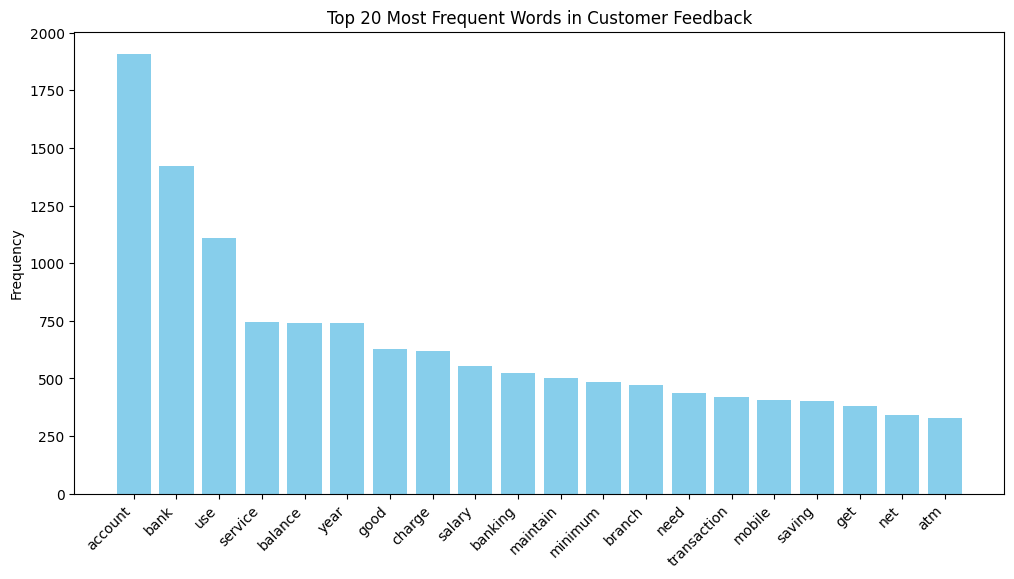

In [10]:
# Bar chart of the 20 most common words
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words in Customer Feedback')
plt.ylabel('Frequency')
plt.show()

- The word cloud highlights the most prominent terms in customer feedback.
- The bar chart shows the top 20 most frequent words, giving a sense of common topics and concerns.
- These visualizations can guide further analysis, such as identifying key satisfaction drivers or recurring issues.

The bar chart displays the most common words found in customer feedback about banking services. Key observations include:
- Account and Bank:

The words "account" and "bank" are by far the most frequently mentioned, highlighting that most feedback is directly related to account management and overall banking experience.
- Service and Use:

High frequencies for "service" and "use" suggest that customers are often discussing the quality of service and the usability of banking products or features.
- Balance, Charge, and Minimum:

Words like "balance," "charge," and "minimum" indicate that customers are particularly concerned with account balance requirements, associated charges, and minimum balance policies.
- Digital and Branch Banking:

The presence of "mobile," "net," and "transaction" alongside "branch" and "atm" shows that both digital and traditional banking channels are important topics in customer feedback.
- Salary and Saving:

"Salary" and "saving" accounts are frequently discussed, suggesting these are the most common account types or the ones with the most feedback—possibly due to their features or requirements.
- Customer Needs:

Words like "need," "get," and "good" reflect customer expectations and their desire for better or more convenient banking solutions.
- Conclusion:

Customers are highly focused on account management, service quality, and the financial requirements imposed by banks. Both digital and physical banking experiences are important, and there is a clear emphasis on the need for user-friendly, low-fee, and flexible account options.

## 2. Feature Engineering & NLP Pipeline Development
### 2.1. Text Vectorization Pipeline
Let first explain the approaches and then implement the best one:
##### a. TF-IDF Vectorization:
TF-IDF (Term Frequency-Inverse Document Frequency) is a classic and effective way to convert text into numerical features.
- Pros: Simple, interpretable, captures word importance
- Cons: Doesn't capture semantic meaning, high dimensionality
##### b. Pre-trained Word Embeddings (like Word2Vec, GloVe):
We can use embeddings like GloVe or Word2Vec to represent each review as an average of its word vectors.
- Pros: Captures semantic meaning, lower dimensionality
- Cons: Requires pre-trained models, more complex
##### c. Sentiment Lexicon Features:
Predefined lists of words labeled with sentiment scores.
- Pros: Domain-specific, interpretable
- Cons: May miss context, requires manual lexicon creation

For this bank customer feedback analysis, we use a combination of TF-IDF and sentiment lexicon features because:
- TF-IDF will help capture important terms specific to banking
- Sentiment lexicons can help identify emotional content

This combination provides both statistical and semantic features.

In [16]:
# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')

class FeatureEngineering:
    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words='english'
        )
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        
    def extract_sentiment_features(self, text):
        """Extract sentiment scores using VADER"""
        scores = self.sentiment_analyzer.polarity_scores(text)
        return {
            'compound_score': scores['compound'],
            'pos_score': scores['pos'],
            'neg_score': scores['neg'],
            'neu_score': scores['neu']
        }
    
    def extract_tfidf_features(self, tokens_list):
        """Extract TF-IDF features from preprocessed tokens"""
        # Join tokens back into text
        texts = [' '.join(tokens) for tokens in tokens_list]
        # Fit and transform
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(texts)
        return tfidf_matrix
    
    def extract_lexical_features(self, tokens_list):
        """Extract lexical features from tokens"""
        features = []
        for tokens in tokens_list:
            # Calculate basic statistics
            feature_dict = {
                'token_count': len(tokens),
                'unique_token_count': len(set(tokens)),
                'lexical_diversity': len(set(tokens)) / len(tokens) if tokens else 0,
                'avg_token_length': np.mean([len(token) for token in tokens]) if tokens else 0
            }
            features.append(feature_dict)
        return pd.DataFrame(features)
    
    def engineer_features(self, df):
        """Combine all feature engineering steps"""
        # Create a copy to avoid modifying original data
        df_processed = df.copy()
        
        # Extract sentiment features from original text
        sentiment_features = df_processed['review'].apply(self.extract_sentiment_features)
        sentiment_df = pd.DataFrame(sentiment_features.tolist())
        
        # Extract TF-IDF features from cleaned tokens
        tfidf_matrix = self.extract_tfidf_features(df_processed['review_clean_tokens'])
        tfidf_df = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
        )
        
        # Extract lexical features
        lexical_df = self.extract_lexical_features(df_processed['review_clean_tokens'])
        
        # Combine all features
        df_processed = pd.concat([
            df_processed,
            sentiment_df,
            tfidf_df,
            lexical_df
        ], axis=1)
        
        return df_processed

if __name__ == "__main__":    
    # Engineer features
    feature_engineer = FeatureEngineering()
    df_with_features = feature_engineer.engineer_features(df)
    
    # Save processed data
    df_with_features.to_csv('processed_data.csv', index=False)
    print("Feature engineering completed and data saved to 'processed_data.csv'") 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sghas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sghas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Feature engineering completed and data saved to 'processed_data.csv'


We've implemented a comprehensive feature engineering solution that combines TF-IDF and sentiment lexicon features. Here's what the code does:
##### Text Preprocessing:
- Converts text to lowercase
- Removes special characters and digits
- Removes extra whitespace
- Handles missing values gracefully
##### TF-IDF Features:
- Uses scikit-learn's TfidfVectorizer
- Captures up to 5000 most important features
- Includes both unigrams and bigrams (1-2 word combinations)
- Removes common English stopwords
##### Sentiment Features:
- Uses VADER (Valence Aware Dictionary and sEntiment Reasoner)
- Extracts four sentiment scores:
  - Compound score (overall sentiment)
  - Positive score
  - Negative score
  - Neutral score